# End to End multiclass dog breed classification 🐶 

This notebook builds an end to end multiclass image classifier using Tensorflow and Tensorflow hub.

## 1.Problem
Identifying breed of dog given image of the dog.

## 2.Data
The data we are using is from kaggle dog breed identification competetion

## 3.Evaluation
The evaluation is a file with predictions probabilities for each dog breed of each test image

## 4.Features
Some information about the data 
* We are dealing with images (unstructured data ) 
* There are 120 breeds of dog that means there are 120 different classes
* There are around 10000 + images in training set with labels
* There are around 10000+ images in test set with no labels because we have to predict them 


### Get our workspace ready

In [1]:
#import necessary tools
import tensorflow_hub as hub
import tensorflow as tf
print("TF version" , tf.__version__)
print("hub version",hub.__version__)


# Chcek for gpu availability
print("GPU","available(YES!!!)" if tf.config.list_physical_devices("GPU")  else "Not available :(")

2023-12-18 23:23:32.850008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF version 2.12.0
hub version 0.15.0
GPU available(YES!!!)


### Getting our data ready (turning into tensors)

With all machine learning models , our data has to be in numerical format . So that's what we'll be doing first. Turning our images into tensors(numerical representation).

Let's start by accessing our data and checking the labels


In [2]:
#Check out the labels of our data
import pandas as pd
labels_csv=pd.read_csv("dog-breed-identification/labels.csv")
print(labels_csv.head())
labels_csv.describe()

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

<Axes: xlabel='breed'>

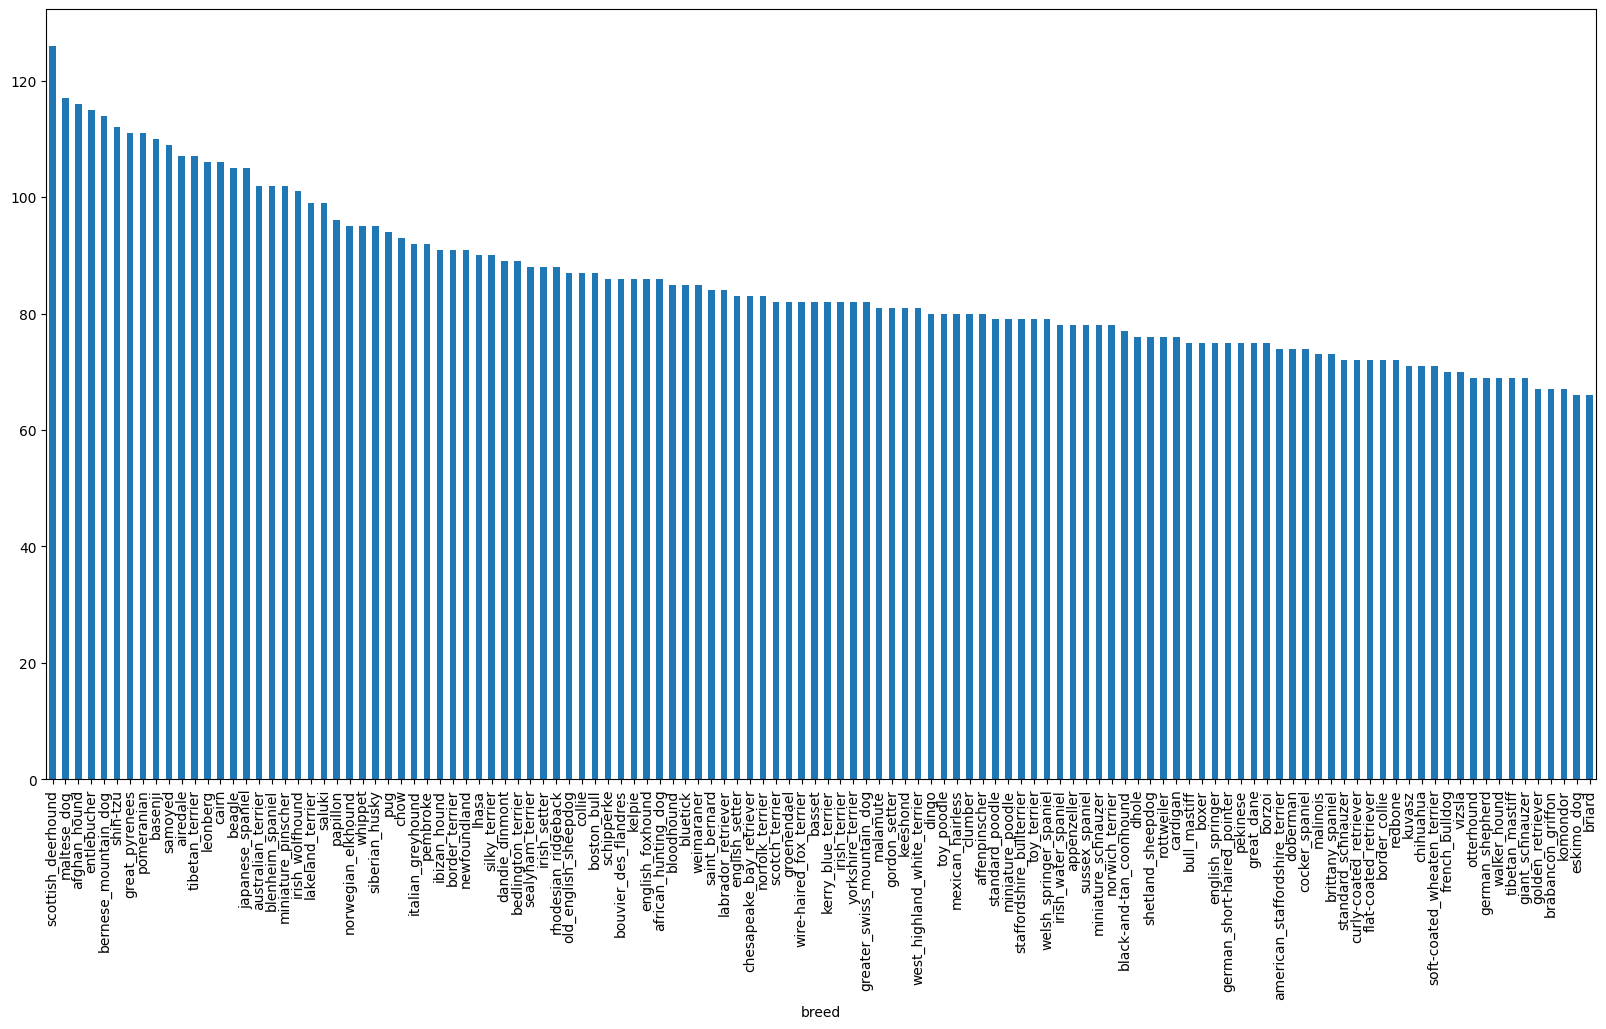

In [3]:
#How many images are there of each breed?
import matplotlib as plt
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [4]:
labels_csv['breed'].value_counts().median()

82.0

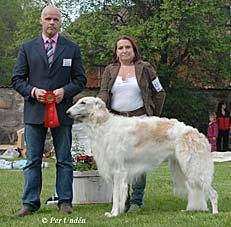

In [5]:
#Let's view an image
from IPython.display import Image
Image('dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg')

#### Getting images and their labels

Lets get a list of all our image path names

In [6]:
#Create path names from image ID's

filenames=["dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv['id']]

#Check the first 10
filenames[:10]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [7]:
#check whether the number of files match the actual image files

import os
if len(os.listdir("dog-breed-identification/train/"))==len(filenames):
    print("files length matched")
else:
    print("Not matched")



files length matched


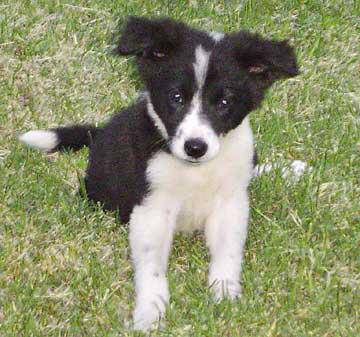

In [47]:
#one more check
Image(filenames[81])

Since we have now got our training image filepaths in a list , lets prepare our labels

In [9]:
import numpy as np
labels=labels_csv['breed']
labels=np.array(labels)
labels


array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [10]:
#See number of labels matches number of filenmaes
if len(labels)==len(filenames):
    print("Number of labels matches the number of filenames")
else:
    print("Not matches")

Number of labels matches the number of filenames


In [11]:
#Find the unique label values
unique_labels=np.unique(labels)
len(unique_labels)

120

In [12]:
#Turn every label into a booelan array
boolean_labels=[label==unique_labels for label in labels]

boolean_labels[:2]


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

#### Creating our own validation set (since the data from kaggle doesn't come with a validation set)

In [13]:
#Setup X and y variables
X=filenames
y=boolean_labels

We are goint to experimenting with 1000 images and increase as we need

In [14]:
NUM_IMAGES=1000 


In [15]:
#Lets split our data into train and validatoin sets
from sklearn.model_selection import train_test_split

#Split them into training and validation of total size NUM_IMAGES
X_train,X_val,y_train,y_val=train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=42)
len(X_train),len(X_val),len(y_train),len(y_val)

(800, 200, 800, 200)

In [16]:
X_train[:2],y_train[:2]

(['dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

### Preprocessing images (turning images to tensors)

To preprocess our images to tensors we are going to write a function which is going to do this:
1. Take an image filepath as input
2. Use tensorflow to read the file and save it to a variable `image`
3. Turn our `image` (jpg) to tensor
4. Normalize our image (convert color channel from 0-255 to 0-1)
4. Resize the image to shape of (224,224)
5. Return the modified image

In [17]:
#Convert image to numpy array
from matplotlib.pyplot import imread
image=imread(filenames[42])
image.shape

(257, 350, 3)

In [18]:
#We can convert image to tensor using constant function
tf.constant(image)

2023-12-18 23:23:54.369727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-18 23:23:54.371075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

In [19]:
#Now we will build the samples

#Define the image size
IMG_SIZE=224

#Create a function for preprocessing image
def process_image(image_path,IMG_SIZE=IMG_SIZE):
    """
    Takes an image file path and converts the image to Tensor
    """

    #Read in an image file
    image= tf.io.read_file(image_path)
    #Turn jpeg image to numerical tensor with 3 color channels (Red,Green,Blue)
    image=tf.image.decode_jpeg(image,channels=3)
    #Convert color channel values from 0-255 to 0-1
    image=tf.image.convert_image_dtype(image,tf.float32)
    #Resize the image to our desired value (224,224)
    image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

    return image


#### Turning our data into batches

Why turn our data to batches ?

Lets say you trying to process 10000+ images in one go ... they all might not fit into memory

So thats why we do about 32(this is batch size) images at a time(you can manually adjust batch size if need be)

In order to use Tensorflow effectively , we need our data in form of tensorflow tuples which look like this: `(image,label)`

In [20]:
#Create a simple function to return a tuple(image,label)

def get_image_label(image_path,label):
    image=process_image(image_path)
    return image,label

In [21]:
#Demo of above function
(process_image(X[42],224),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.2389375 ],
         ...,
         [0.29325107, 0.5189916 , 0.32155466],
         [0.29721776, 0.52466875, 0.33030325],
         [0.2948505 , 0.5223015 , 0.3340662 ]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692955, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247737],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634811, 0.03442093

Now we've got a way to turn our data into tuples of Tensors in the form : (`image,label`) , lets make a function to turn all our data(`X & y`) into batches

In [90]:
#Define the batch size(32)
BATCH_SIZE=32

#Crate a function to turn data to batches
def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it is training and does not shuffle is it is validation data.
    Also accepts test data as inputs(no labels)
    """
    #If the data is test dataset we probably wont have labels
    if test_data:
        print("Creating test data batches....")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepaths no labels
        data_batch=data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    #If the data is valid dataset
    elif valid_data:
        print("Creating valid data batch....")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data_batch=data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print("Create training data batches....")
        #Turn filepaths and images into tensors
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        #Shuffling pathnames and labels before mapping image processor function is faster than shuffling images 
        data=data.shuffle(buffer_size=len(X))
        #Create (image,label) tuples (this also turns the image path into a preprocessed image)
        data=data.map(get_image_label)
        #Turn data into batches
        data_batch=data.batch(BATCH_SIZE)
        return data_batch

In [23]:
#Creating validation and training data batches
train_data=create_data_batches(X_train,y_train)
valid_data=create_data_batches(X_val,y_val,valid_data=True)

Create training data batches....
Creating valid data batch....


In [24]:
#Check out the different atrributes of our data batches
train_data.element_spec,valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

#### Visualizing the data batches


In [25]:
#create a function for visualizing images in a data batch
import matplotlib.pyplot as plt
def show_25_image(images,labels):
    """
    Displays a plot of 25 image and their labels from a data batch
    """
    #setup the figure 
    plt.figure(figsize=(10,10))
    #loop through 25(to display 25 images)
    for i in range (25):
        #create subplots (5rows,5columns)
        ax=plt.subplot(5,5,i+1)
        #Display the image 
        plt.imshow(images[i])
        #Add the image label as the title 
        plt.title(unique_labels[labels[i].argmax()])
        #Trun the grid lines off
        plt.axis("off")
        


2023-12-18 23:23:55.093538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [800]
	 [[{{node Placeholder/_0}}]]
2023-12-18 23:23:55.094429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [800,120]
	 [[{{node Placeholder/_1}}]]


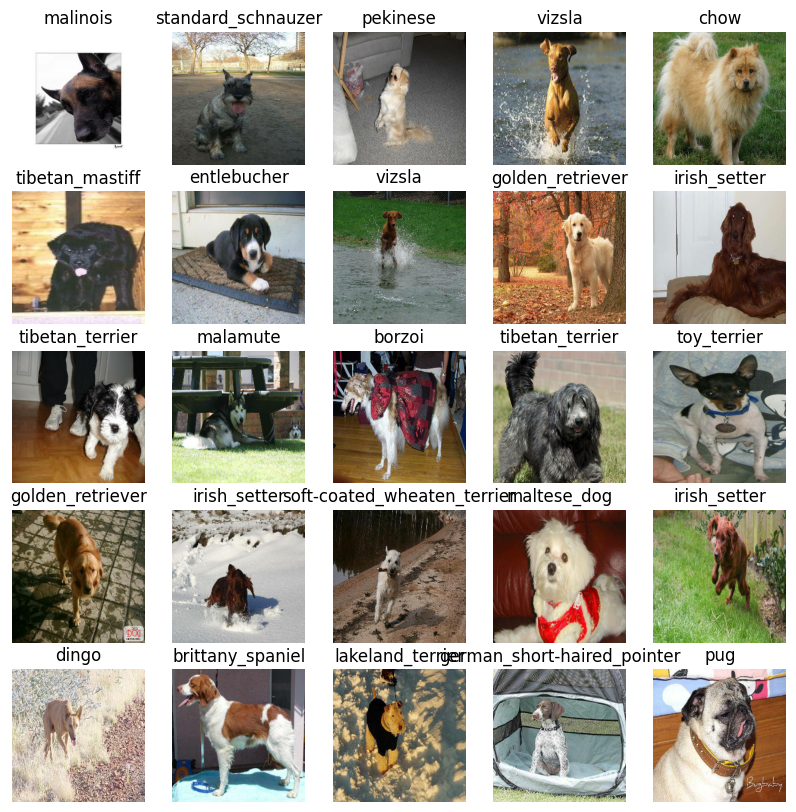

In [26]:
#Now lets visualize the data in training batch
#to visualize the iamges we hvae to unbatch the batches
train_images,train_labels=next(train_data.as_numpy_iterator())
show_25_image(train_images,train_labels)

2023-12-18 23:23:56.815887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [200,120]
	 [[{{node Placeholder/_1}}]]


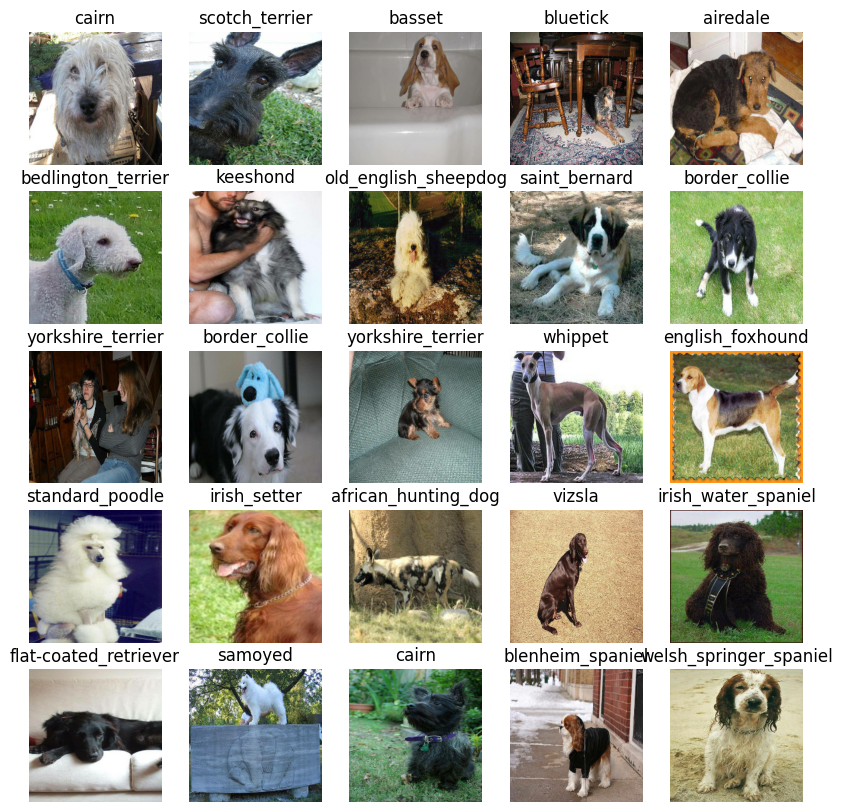

In [27]:
#Now lets visualize validation data 
val_images,val_labels=next(valid_data.as_numpy_iterator())
show_25_image(val_images,val_labels)

## Building a model

Before we build the model there are few things we need to define :

* The input shape (our image shape in form of tensors to the model ) 
* The output shape (image lables , in form of tensors) of our model 
* The url of the model we want to use

In [28]:
#Setup input shape to the model
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3] #batch,height,weight,colour channels

#Setup output shape of our model
OUTPUT_SHAOPE=len(unique_labels)

#Setup model URL from Tensorflow hub

MODEL_URL="https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1"



Now we have get our inputs and outputs and model ready to go . Lets put them together into keras deep learning model
Knowing this lets create a function which :
* Takes an input shape , o/p shape and model we have choosed as parameter
* Defines the layers in keras model in sequential fashion(do this first,then that,then that)
* Compiles the model (tell the model the input shape it will be getting )
* Returns the model 

In [29]:
#Create a function which builds keras model 

def create_model (input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAOPE,model_url=MODEL_URL):
    print("Building model with ",model_url)

    #Setup the model layers
    model =tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), #Layer1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAOPE,activation="softmax") #Layer 2 output layer
    ])

    #Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"]
    )
    #Build model
    model.build(INPUT_SHAPE)
    return model

In [30]:
model=create_model()
model.summary()

Building model with  https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress , check its progress and stop training early if a model stops improving

We'll create two callbacks one for tensorboard which helps track our model and another for early stopping which stops our model for training too long

#### Tensorboard Callback'

To setup tensorboard callback we need to do 3 things 
1. Load the tensorboard notebook extension
2. Create a Tensorboard callback which is able to save logs to a directory and pass it to our model's fit() function.
3. visualize our models training log with the `%tensorboard` magic function(we'll do this after model training)


In [31]:
#Step 1
%load_ext tensorboard

In [32]:
import datetime
#step 2
def create_Tensorboard_callback():
    #create a log directory for storing all the logs

    logdir=os.path.join("/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/logs",
                        #make it so logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H$M$S"))
    return tf.keras.callbacks.TensorBoard(logdir)

#### Early Stopping callback

It helps our model from overfitting by stopping the training if a certain evaluation metrice stop improving.

In [33]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

### Training a model

Our model is going to train on a subset of 1000 data so that we make sure everything is working.

In [34]:
NUM_EPOCHS=100

In [35]:
if tf.config.list_physical_devices("GPU"):
    print("yes")

yes


Let's create a function which trains a model
* create a function called create_model
* Set up a Tensorboard callback using create_tensorboard_Callback function
* Call the fit() function in our model passing the training data ,  number of epochs to train for , validation data and callbacks we'd like to use
* Return the model 

In [36]:
#Build a function to train and return the trained model
def train_model():
    """
    Train the given model and return the trained version
    """
    #create a model
    model=create_model()

    #Create a new tensorboard session everytime we train the model
    tensorboard=create_Tensorboard_callback()

    #Fit the model to the data passing the callbacks we have created 
    model.fit(x=train_data,epochs=NUM_EPOCHS,validation_data=valid_data,validation_freq=1,callbacks=[tensorboard,early_stopping])

    return model


In [37]:
model=train_model()

Building model with  https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1
Epoch 1/100


2023-12-19 19:39:01.049962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,1001]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-12-19 19:39:01.050073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/zeros_like/StatefulPartitionedCall' with dtype float and shape [?,1001]
	 [[{{node gradients/zeros_like/StatefulPartitionedCall}}]]
2023-12-19 19:39:01.050128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicat

25/25 [==============================] - ETA: 0s - loss: 4.7130 - accuracy: 0.0875

2023-12-19 19:39:10.769858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 13s 297ms/step - loss: 4.7130 - accuracy: 0.0875 - val_loss: 3.4853 - val_accuracy: 0.2350
Epoch 2/100
25/25 [==============================] - 5s 220ms/step - loss: 1.7097 - accuracy: 0.6837 - val_loss: 2.2449 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 6s 221ms/step - loss: 0.5852 - accuracy: 0.9400 - val_loss: 1.7176 - val_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 6s 229ms/step - loss: 0.2631 - accuracy: 0.9850 - val_loss: 1.5255 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 6s 224ms/step - loss: 0.1534 - accuracy: 0.9962 - val_loss: 1.4489 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 5s 220ms/step - loss: 0.1035 - accuracy: 0.9975 - val_loss: 1.4049 - val_accuracy: 0.6600
Epoch 7/100
25/25 [==============================] - 5s 220ms/step - loss: 0.0779 - accuracy: 1.0000 - val_loss: 1.3768 - val_accuracy: 0.6550
Epoch 8/10

#### Checking the tensorboard logs
The tensorboard magic function (%tensorboard) will access the logs directory we created earlier and visualize it 

In [39]:
#%tensorboard --logdir /Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/logs/20231219-19$M$S


In [40]:
valid_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

### Making and evaluating predictions using trained model


In [41]:
#Making predictoins on validation data
predictions=model.predict(valid_data,verbose=1)
predictions

2023-12-19 19:52:24.680374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 209ms/step


array([[6.3230260e-04, 3.0689285e-04, 1.1236712e-03, ..., 2.1363588e-04,
        4.5280536e-05, 3.2792150e-03],
       [2.3757149e-03, 1.0149984e-03, 6.5913019e-03, ..., 2.9053094e-04,
        3.1272441e-03, 3.4790361e-04],
       [2.9717148e-06, 2.8253405e-04, 5.0418821e-05, ..., 1.4935641e-04,
        5.9717637e-05, 1.1046132e-03],
       ...,
       [1.1276870e-05, 8.1818725e-05, 3.0500183e-05, ..., 6.0335042e-05,
        8.2838739e-04, 3.0627035e-04],
       [5.5528479e-03, 2.4182221e-04, 1.6913706e-04, ..., 6.8087102e-05,
        7.5753225e-05, 3.6074265e-03],
       [8.3847868e-04, 4.3172131e-06, 2.7060485e-04, ..., 3.6157032e-03,
        2.5228789e-04, 3.4004808e-04]], dtype=float32)

In [42]:
predictions.shape

(200, 120)

In [44]:
#First prediction
index=42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_labels[np.argmax(predictions[index])]}")

[5.51643134e-05 4.35666698e-05 4.20836222e-05 4.03909544e-05
 1.10804127e-03 8.54076570e-05 1.79239520e-04 4.21744044e-04
 9.18128993e-03 4.98335548e-02 7.07191793e-05 2.35311400e-05
 6.49699825e-04 7.88475294e-03 1.23677973e-03 8.08039866e-03
 3.42790823e-04 5.52521087e-04 6.22457126e-04 3.40593542e-04
 2.09307749e-04 9.81132034e-04 5.11586768e-05 3.29330360e-04
 2.97606569e-02 3.43593332e-04 5.38188979e-05 1.35063747e-04
 9.43825813e-04 6.11021605e-05 6.86161802e-05 2.26569391e-04
 6.43644598e-05 5.50281729e-05 1.24960017e-04 3.27774796e-05
 3.01346823e-04 3.93995957e-04 1.19747972e-04 2.89215207e-01
 3.62292398e-04 9.40293539e-05 5.90287335e-03 7.80328537e-06
 3.87712877e-04 6.20329010e-05 4.11630957e-04 5.84289955e-04
 1.99204500e-04 5.17811219e-04 3.13521945e-04 3.58187855e-04
 7.28835934e-04 1.45775324e-03 1.89435028e-04 9.72629117e-04
 3.01000720e-04 9.51826660e-05 2.27206823e-04 8.55543985e-05
 5.43948045e-05 4.47383354e-04 1.57831964e-05 8.03185831e-05
 7.82778836e-04 2.979471

* Above prediction probability is great but we want to be able to do it at scale.
* And it would be better if we can imagine the prediction.

**Note**: Prediction probabilites are also called confidence level

In [46]:
#Turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
    """
    Turns array of prediction probabilities into labels
    """
    return unique_labels[np.argmax(prediction_probabilities)]

get_pred_label(predictions[81])

'dingo'

In [54]:
#Create a function to unbatch a dataset
def unbatchfy(data):

    images_=[]
    labels_=[]

    #Loop through unbatch dataset
    for image,label in data.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(unique_labels[np.argmax(label)])

    return images_,labels_

#unbatchify the validation data
val_images,val_labels=unbatchfy(valid_data)
val_images[0],val_labels[0]

2023-12-20 00:20:19.059216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [200,120]
	 [[{{node Placeholder/_1}}]]


(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [55]:
get_pred_label(val_labels[0])

'affenpinscher'

Lets make a function to make it all more visualize


We'll create a function which:
* Takes an array of prediction probabilities an array of truth labels and an array of images and integers
* convert prediction probabilities into prediction labels
* Plot the predicted label , its predicted probability , the truth label and the target image on a single plot

In [62]:
def plot_pred(prediction_probabilities,labels,images,n=1):
    """
    View the prediction , ground truth and image for sample n
    """
    pred_prob,true_label,image=prediction_probabilities[n],labels[n],images[n]


    #Get the pred label
    pred_label=get_pred_label(pred_prob)

    #plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    #Change the color of title based on prediction is true or false
    if pred_label==true_label:
        color="green"
    else:
        color="red"

    #Change plot title to be predicted ,  probability of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label,np.max(pred_prob)*100,true_label),color=color)


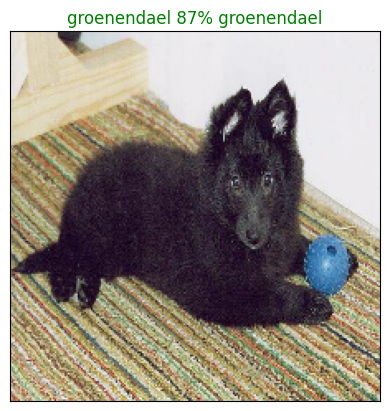

In [65]:
plot_pred(prediction_probabilities=predictions,labels=val_labels,images=val_images,n=77)

Now we've got one function to visualize our models top prediction,lets make another to view our model top 10 predictions

This function will: 
* Take an input of prediction probabilities array and a ground truth array and an integer
* find prediction using `get_pred_label()`
* FInd the top 10: 
    * Prediction probabilities indexes
    * Prediction probabilities values
    * Prediction labels
* plot top 10 Prediction probabilities labels and values coloring the label greeen

In [66]:
def plot_pred_conf(prediction_probabilities,labels,n=1):
    pred_prob,true_label=prediction_probabilities[n],labels[n]

    #Get the predicted label
    pred_label=get_pred_label(pred_prob)

    #find the top 10 prediction confidence indexes
    top_10_pred_indexes=pred_prob.argsort()[-10:][::-1]

    ##find the top 10 prediction confidence values
    top_10_pred_values=pred_prob[top_10_pred_indexes]

    #find the top 10 prediction labels
    top_10_pred_labels=unique_labels[top_10_pred_indexes]

    #setup plot
    top_plot=plt.bar(np.arange(len(top_10_pred_labels)),top_10_pred_values,color="grey")

    plt.xticks(np.arange(len(top_10_pred_labels)),labels=top_10_pred_labels,rotation="vertical")

    #change the color of true label
    if np.isin(true_label,top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels==true_label)].set_color("green")
    else:
        pass



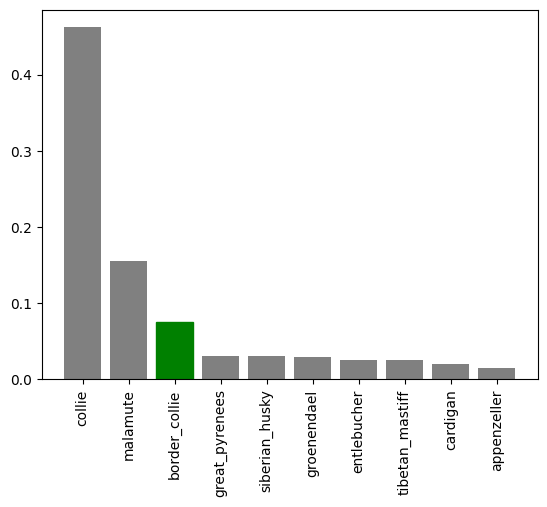

In [67]:
plot_pred_conf(prediction_probabilities=predictions,labels=val_labels,n=9)

Now we have got some functions to help us visualize our predictions and evaluate our model , lets check out

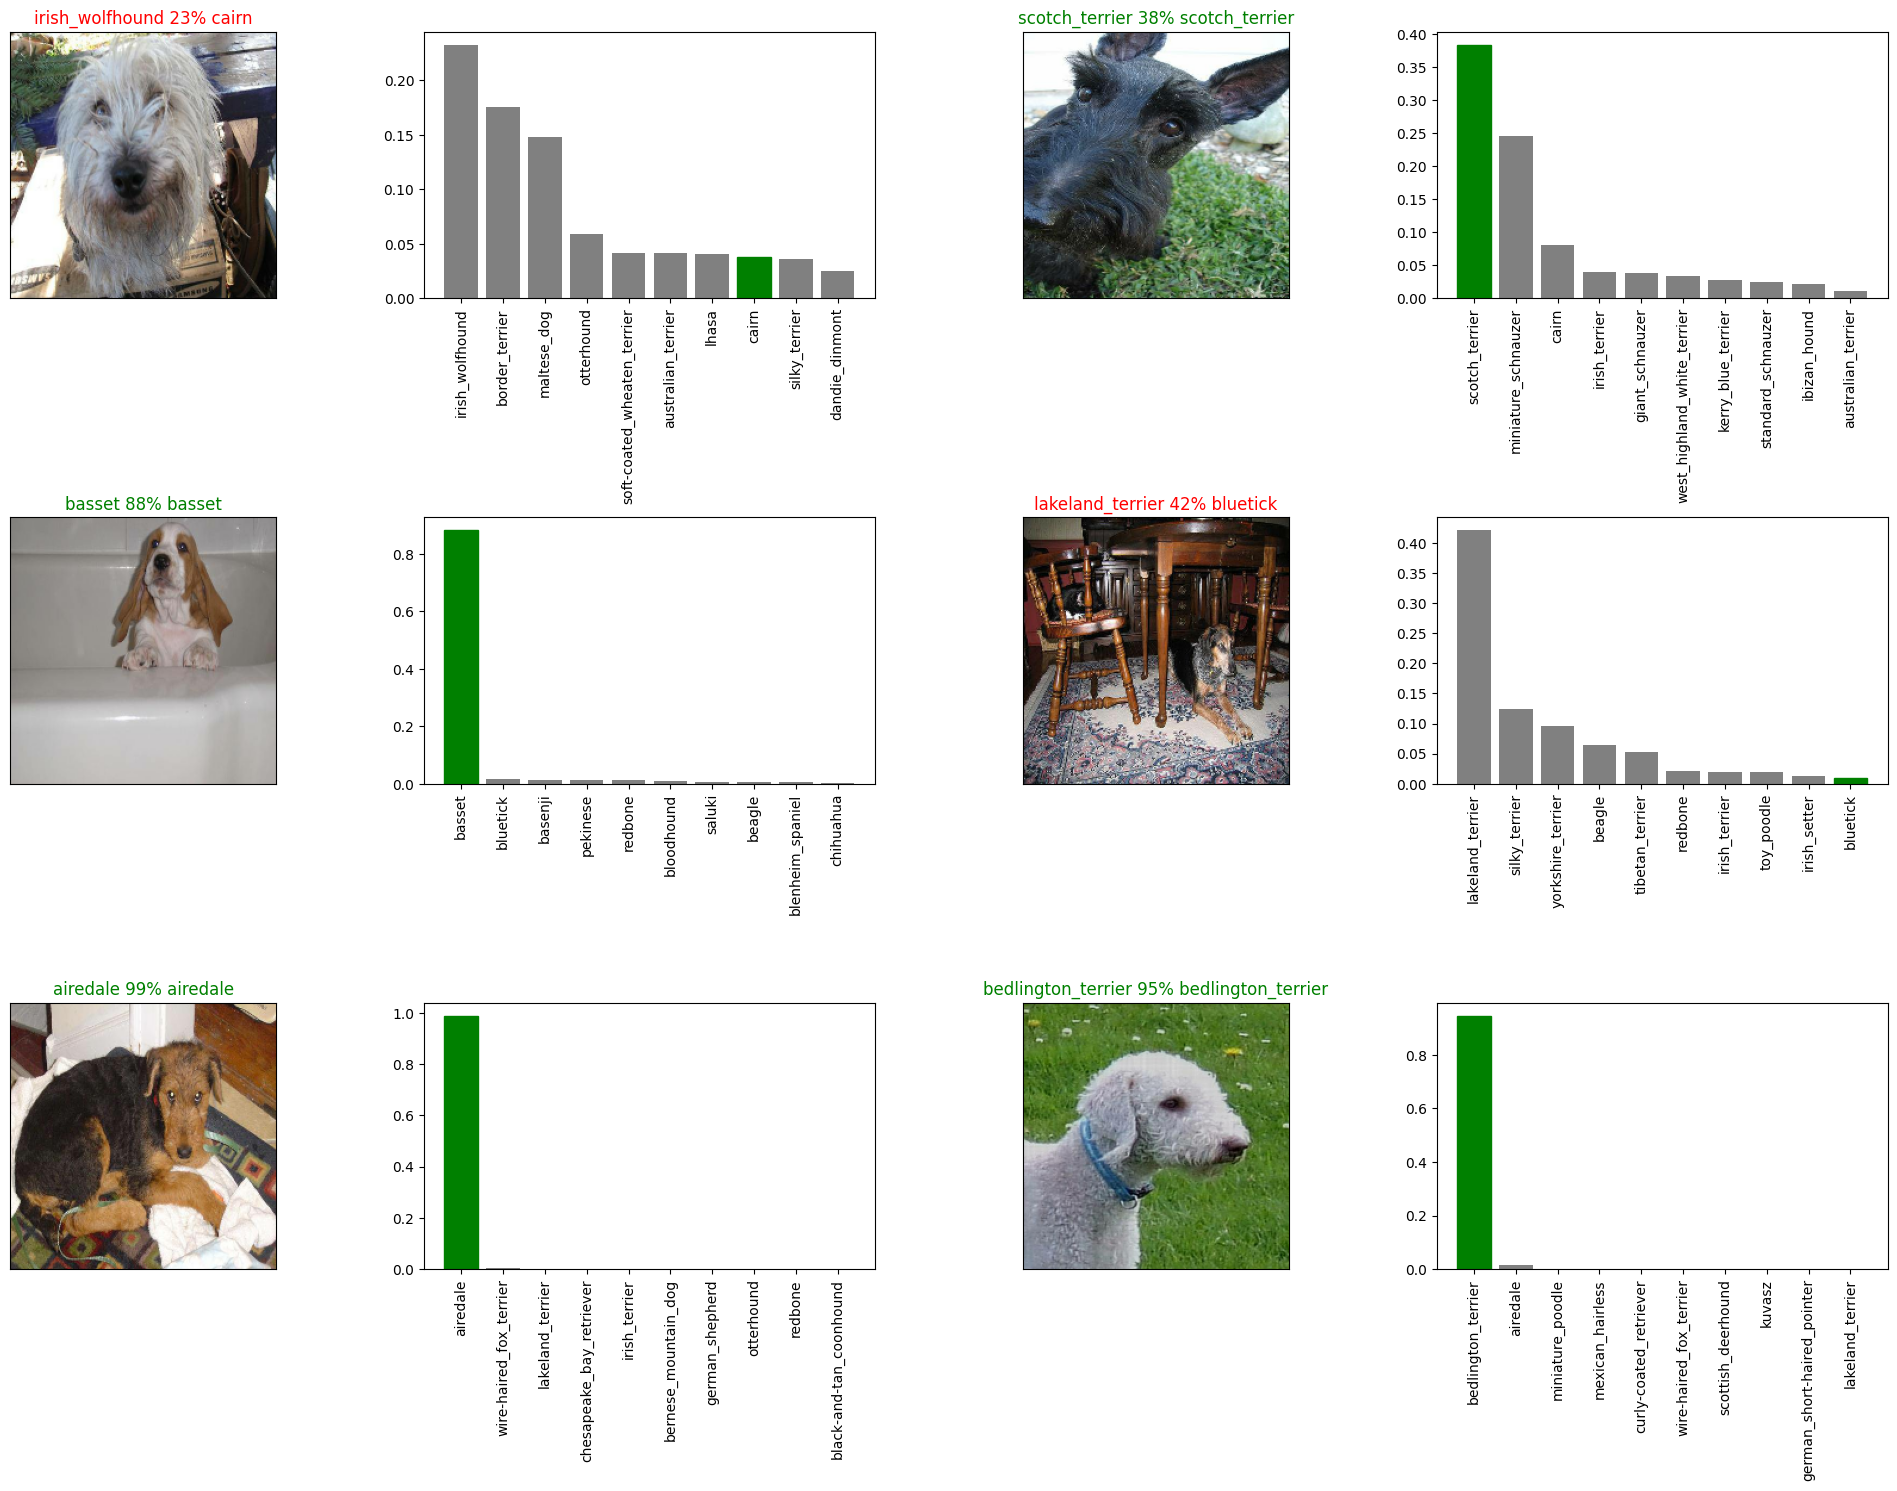

In [70]:
#lets check few predictions and their values 
i_multiplier=0
num_rows=3
num_cols=2

num_images=num_cols*num_rows

plt.figure(figsize=(10*num_cols,5*num_rows))

for i in range (num_images):
    plt.subplot(num_rows,2*num_cols,2*i+1)
    plot_pred(prediction_probabilities=predictions,labels=val_labels,images=val_images,n=i+i_multiplier)
    plt.subplot(num_rows,2*num_cols,2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,labels=val_labels,n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

### Saving and reloading a trained model


In [71]:
#Create a function to save model 

def save_model(model,suffix=None):

    modeldir=os.path.join ("/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/model",datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))

    model_path=modeldir+ "-" +suffix + ".h5"   #save format of model

    print(f"Saving model to {model_path}....")
    model.save(model_path)
    return model_path

In [110]:
#Create a function to load a model 
def load_model (model_path):
    print(f"Loading saved model from {model_path}....")

    model=tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})

    return model

In [73]:
save_model(model,suffix="1000-images-mobilenet-v2-Adam")

Saving model to /Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/model/20231220-01461703016987-1000-images-mobilenet-v2-Adam.h5....


'/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/model/20231220-01461703016987-1000-images-mobilenet-v2-Adam.h5'

In [75]:
loaded_model_1000_images=load_model('/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/model/20231220-01461703016987-1000-images-mobilenet-v2-Adam.h5')

Loading saved model from /Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/model/20231220-01461703016987-1000-images-mobilenet-v2-Adam.h5....


In [78]:
#Evaluate pre save model and loaded model
print(model.evaluate(valid_data))
loaded_model_1000_images.evaluate(valid_data)

7/7 [==============================] - 3s 330ms/step - loss: 1.3362 - accuracy: 0.6550
[1.3361932039260864, 0.6549999713897705]
7/7 [==============================] - 2s 294ms/step - loss: 1.3362 - accuracy: 0.6550


[1.3361932039260864, 0.6549999713897705]

## Training the dog model on full data

In [79]:
len(X),len(y)

(10222, 10222)

In [80]:
#Create data batch with full dataset
full_data=create_data_batches(X,y)


Create training data batches....


In [81]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [82]:
#Create a model of full model
full_model=create_model()

Building model with  https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1


In [83]:
#Create full model callbacks
full_model_tensorboard=create_Tensorboard_callback()
#no validation set on training data so we cannot monitor validation accurcay
full_model_early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)

In [84]:
#Fit the full model to full data
full_model.fit(x=full_data,epochs=NUM_EPOCHS,callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100


2023-12-21 00:30:12.587210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [10222,120]
	 [[{{node Placeholder/_1}}]]
2023-12-21 00:30:12.587811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [10222,120]
	 [[{{node Placeholder/_1}}]]
2023-12-21 00:30:14.121070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/Stat

320/320 [==============================] - 111s 330ms/step - loss: 1.3264 - accuracy: 0.6750
Epoch 2/100
320/320 [==============================] - 103s 320ms/step - loss: 0.3982 - accuracy: 0.8822
Epoch 3/100
320/320 [==============================] - 105s 327ms/step - loss: 0.2336 - accuracy: 0.9363
Epoch 4/100
320/320 [==============================] - 108s 339ms/step - loss: 0.1529 - accuracy: 0.9645
Epoch 5/100
320/320 [==============================] - 103s 322ms/step - loss: 0.1049 - accuracy: 0.9790
Epoch 6/100
320/320 [==============================] - 103s 323ms/step - loss: 0.0765 - accuracy: 0.9874
Epoch 7/100
320/320 [==============================] - 103s 321ms/step - loss: 0.0585 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 104s 326ms/step - loss: 0.0461 - accuracy: 0.9939
Epoch 9/100
320/320 [==============================] - 103s 323ms/step - loss: 0.0372 - accuracy: 0.9962
Epoch 10/100
320/320 [==============================] - 104s 323ms/

In [97]:
save_model(full_model,suffix="full-image-set-mobilenetv2-Adam")

Saving model to /Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/model/20231221-19211703166682-full-image-set-mobilenetv2-Adam.h5....


'/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/model/20231221-19211703166682-full-image-set-mobilenetv2-Adam.h5'

In [103]:
import tensorflow as tf

class KerasLayer(tf.keras.layers.Layer):
    # Your layer implementation goes here
    pass


In [111]:
#Load in the full model
loaded_full_model=load_model('/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/model/20231221-01061703100999-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from /Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/model/20231221-01061703100999-full-image-set-mobilenetv2-Adam.h5....


TypeError: Error when deserializing class 'KerasLayer' using config={'name': 'keras_layer_2', 'trainable': False, 'dtype': 'float32', 'handle': 'https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1'}.

Exception encountered: Trying to load a model of incompatible/unknown type. '/var/folders/b6/k96kvnc13csbfl5fm_mr75yh0000gn/T/tfhub_modules/1d7fe63f0ac84fc2b0bc63a7b4bde7244453cf30' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

### Making predictions on test dataset

Since our project has been trained on Tensor batches so our test data also have to be converted into same format to make predictions

We will use the function made above `create_data_batches()` which take filenames as input and convert them into batches.

To make prediction on test data we will: 
* Get the test images filename
* Convert the filenames into test data batches
* Make a predictions array by passing the test batches into the `predict()` method called by our model


In [125]:
#Load test images filename
test_path='/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/dog-breed-identification/test/'
test_filenames=[test_path + fname for fname in os.listdir(test_path)]
test_filenames[:1]

['/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/dog-breed-identification/test/266490a2b053a4a3bf68e779f28fb5a9.jpg']

In [115]:
len(test_filenames)


10357

In [116]:
#Create a test data batches
test_data=create_data_batches(test_filenames,test_data=True)

Creating test data batches....


In [117]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [118]:
#Make predictions on test data using loaded model
test_predictions=full_model.predict(test_data,verbose=1)

2023-12-21 19:48:25.100231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10357]
	 [[{{node Placeholder/_0}}]]


324/324 [==============================] - 102s 310ms/step


In [120]:
#Save the predictions(numpy array ) to a csv file (for access later)
np.savetxt("/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/dog-breed-identification/preds_array.csv",test_predictions,delimiter=',')

In [ ]:
#Load predictions numpy array from csv file
test_predictions=np.loadtxt("/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/dog-breed-identification/preds_array.csv",delimiter=",")

### Preparing test dataset prediction for kaggle
To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the unique_breeds list and the test_predictions list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [122]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_labels))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [126]:
# Append test image ID's to predictions DataFrame

preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

id affenpinscher afghan_hound  \
0  266490a2b053a4a3bf68e779f28fb5a9           NaN          NaN   
1  dae9fd18836d8df20989ef0101771d4b           NaN          NaN   
2  079a40f22b0fad9a66f76797b62bb930           NaN          NaN   
3  ab8462f9a501d362041d47582fddc9ad           NaN          NaN   
4  8895089b432e020cc42e6262b5a1c2dd           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [128]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_labels)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  266490a2b053a4a3bf68e779f28fb5a9   3.431779e-10  4.167799e-06   
1  dae9fd18836d8df20989ef0101771d4b   1.075299e-02  9.277410e-04   
2  079a40f22b0fad9a66f76797b62bb930   3.536237e-08  5.396687e-11   
3  ab8462f9a501d362041d47582fddc9ad   3.964115e-10  5.513266e-09   
4  8895089b432e020cc42e6262b5a1c2dd   5.767310e-12  4.812616e-11   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         6.128287e-09  6.430750e-07                    5.257983e-13   
1         6.009016e-06  2.245558e-07                    1.702373e-07   
2         2.441521e-13  4.824907e-11                    2.946561e-11   
3         4.466024e-12  9.291282e-09                    9.181479e-12   
4         1.001230e-08  1.545585e-12                    7.996365e-10   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  2.141207e-06        6.289898e-13  1.340220e-10  1.012276e-03  ...   
1  2.784300e-08        2.239053e-03  2.578083e-09  1.066463e-07  ...   
2  1.599736e-12        1.511249e-12  2.831875e-12  3.001632e-13  ...   
3  1.506267e-08        1.324368e-09  6.503346e-12  1.485120e-10  ...   
4  1.637142e-10        4.501758e-08  1.995267e-04  5.596748e-07  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.727744e-10  4.738669e-10  6.304957e-06  4.617086e-07  4.262355e-07   
1  1.635643e-07  8.741811e-07  2.585275e-07  9.981063e-05  1.301324e-04   
2  3.375372e-14  1.085193e-12  3.540453e-13  4.196222e-12  1.021957e-11   
3  2.253320e-09  8.039560e-11  1.748178e-10  1.295482e-08  9.209458e-11   
4  4.956606e-10  1.229225e-08  8.738478e-10  1.061925e-11  5.099829e-11   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            8.706612e-13                 3.198601e-09  3.780210e-06   
1            8.641753e-11                 9.188359e-07  1.457488e-06   
2            3.607618e-13                 7.634308e-14  4.937416e-14   
3            2.270623e-07                 2.205155e-10  8.683321e-12   
4            1.040796e-09                 1.852344e-09  4.951244e-08   

   wire-haired_fox_terrier  yorkshire_terrier  
0             7.023566e-10       9.279602e-13  
1             1.004817e-06       3.521089e-08  
2             2.142685e-12       2.571868e-13  
3             5.827802e-13       8.259806e-08  
4             5.877974e-09       1.186829e-12  

[5 rows x 121 columns]

In [129]:
preds_df.to_csv("/Users/venkateshsanwal/Desktop/ml/tensorflow-neural-network-dog-breed-vision/dog-breed-identification/full_submission_1_mobilienetV2_adam.csv",
                 index=False)